# Series temporales 

## Documentación y "background"

[A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python)](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)
<br><br>


Se usará el **dataset** (https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv) que contiene el **número de pasajeros de una aerolínea en el periodo 1949-1961**.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Importación de datos de una url

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

## Visualización del formato fecha

In [3]:
print(data.head())
print('\n Data Types:')
print(data.dtypes) 

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


**El dtype de la columna 'Month' no tiene todavía formato fecha**

## Transformación de fechas en un objeto datetime y colocación como index

La **variable tiempo en el dataset** se tiene que **convertir** a un objeto **datetime**

In [2]:

file="https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"
dateparse = lambda dates: pd.datetime.strptime(dates,'%Y-%m')
data = pd.read_csv(file,parse_dates=['Month'], # Columna que contiene el objeto fecha
                   index_col='Month',     # Se especifica poner como index una de las columnas, en este caso la columna temporal
                   date_parser=dateparse) # Se especifica la función a aplicar sobre el objeto fecha
data.head()

C:\Users\juanh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


**Analicemos la transformación**:

Parámetro **parse_dates**: Especifica la **columna en el fichero que contiene el objeto fecha** a transformar.   

**index_col**: Se especifica **poner como index** del pandas dataframe **una de las columnas**, en este caso la columna temporal.   

**date_parser**: Se asigna la **función que transforma el tiempo en formato "string" en formato datetime**. Pandas, **por defecto**, lee los datos en formato **‘YYYY-MM-DD HH:MM:SS’**. **S** los datos están en **formato diferente hay que definirlo manualmente**.

In [7]:
print(data.index) #Comprobamos que ahora la fecha está en formato datetime

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)


#Passengers    int64
dtype: object

Podemos ver **ahora** que el **la fecha se ha puesto como index y** que **su dtype es datetime.**

# Definición del time series

In [11]:
type(data)

pandas.core.frame.DataFrame

In [4]:
ts = data['#Passengers'] # El time series es una serie pandas.
type(ts)

pandas.core.series.Series

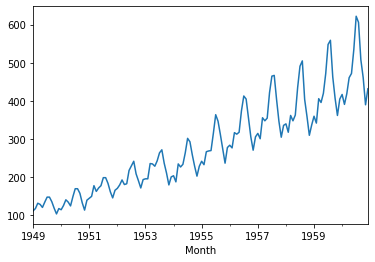

In [13]:
ts.plot() # Método plot, no usamos matlibplot

# ¿Es la serie estacionaria?

 - **Una serie es estacionaria si tanto su media como su varianza son constantes en el tiempo**.

 - Puede haber múltiples motivos por los que comprobar si una serie es estacionaria. Una muy importante es que los **modelos ARIMA necesitan que la serie sea estacionaria para ser aplicados**.

 - **Si la serie no fuera estacionaria hay métodos** que veremos más adelante **para transformarla en estacionaria**.
 
 - **En finanzas la varianza móvil se puede utilizar como medida de la evolución de la volatilidad en un activo.**

## Inspección visual

- Se puede **visualizar si** las **media y desviación estandar móviles varían con el tiempo**.




AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


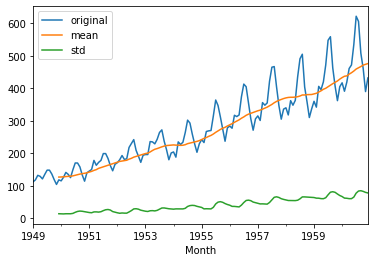

In [26]:
rol_mean=ts.rolling(window=12).mean()
rol_std=ts.rolling(window=12).std()
print(ts.plot(label='original',legend=True))
print(rol_mean.plot(label='mean',legend=True))
print(rol_std.plot(label='std',legend=True))

Claramente **la serie no es estacionaria puesto que tanto mean y std varían con el tiempo** (crecen en este caso)

## Test Dickey-Fuller (DF)


[Reference](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)

   - Este test considera como **hipótesis nula** que **la serie es no estacionaria**.

   - **Para aceptar la hipótesis nula** (serie no estacionaria) **el estadístico** (primer valor del resultado) **ha de ser mayor que los valores críticos**.

   - **Otro criterio** para acepatar la hipótesis nula es que el **p-value sea mayor que 0.05** (95% de confianza).



In [198]:
from statsmodels.tsa.stattools import adfuller as df
result=df(ts,autolag='AIC')
print(result)
print()
print('Estadístico',result[0])
print('P-value',result[1])
print('Valores críticos',result[4])
print()

(0.8153688792060433, 0.9918802434376409, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.692930839019)

Estadístico 0.8153688792060433
P-value 0.9918802434376409
Valores críticos {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}



En este caso **se comprueba cuantitativamente** (ya lo habíamos comprobado visualmente) **que la serie no es estacionaria**:

   - **estadístico > valores críticos**

   - **P-value > 0.05**
   
   - Los criterios anteriores determinan que **se ha de aceptar la hipótesis nula: La serie no es estacionaria**.


## Nueva serie generada por una distribución normal estándar: ¿será estacionaria?

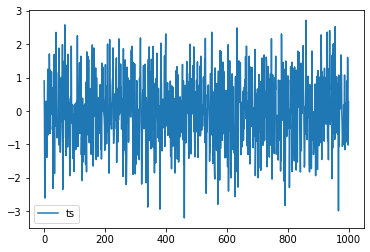

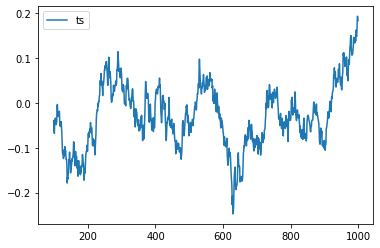

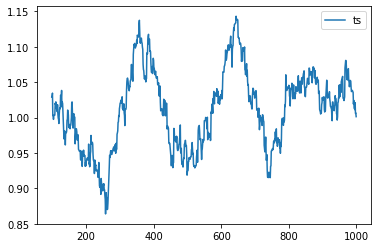

In [48]:
new_ts=np.random.randn(1000)
new_ts=pd.DataFrame(new_ts,columns=['ts'])
new_rol_mean=new_ts.rolling(window=100).mean()
new_rol_std=new_ts.rolling(window=100).std()
new_ts.plot()
new_rol_mean.plot()
new_rol_std.plot()


**Ahora no está tan clara la inspección visual**, ya que puede haber **algún rallie** que nos haga dudar sobre la existencia de tendencias.

In [49]:
new_ts=new_ts['ts'] #We need the time series to be a series to use df test
new_ts

0      0.901883
1     -0.208005
2     -2.603492
3     -0.238244
4     -1.204851
         ...   
995    0.814000
996    1.602715
997    1.007442
998   -1.018209
999    0.278898
Name: ts, Length: 1000, dtype: float64

In [52]:
result=df(new_ts,autolag='AIC')
print(result)
print()
print('Estadístico',result[0])
print('P-value',result[1])
print('Valores críticos',result[4])
print()

(-16.121186070798693, 4.8957544823008794e-29, 4, 995, {'1%': -3.4369391965679257, '5%': -2.86444914142694, '10%': -2.5683189679553546}, 2796.1189732521093)

Estadístico -16.121186070798693
P-value 4.8957544823008794e-29
Valores críticos {'1%': -3.4369391965679257, '5%': -2.86444914142694, '10%': -2.5683189679553546}



Ahora **el estadístico es menor que todos los valores críticos** y además el **P-value está muy por debajo de 0.05**. Por lo tanto**debemos rechazar la hipótesis nula** y concluir que la **serie ES ESTACIONARIA**.

Era **obvio que el resultado tenía que ser éste** ya que habíamos **generado la serie desde una distribución de probabilidad normal estándar** que tiene media cero y varianza 1.

# Convertir una serie en estacionaria.

Hay dos motivos principales por los que una serie puede no ser estacionaria:

   - Presencia de **tendencia**.
   - Presentcia de **estacionalidad**: variabilidad cíclica con un periodo o pseudoperiodo determinado.
  

## Modelizando y eliminando la tendencia

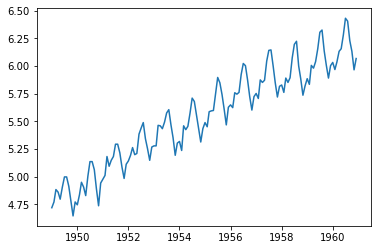

In [559]:
# Tomando logaritmos escalamos la serie temporal
ts_log = np.log(ts)
plt.plot(ts_log);


### Varias formas de modelizar la tendencia

1. **Smoothing** Usando una media móvil tradicional.
2. **Weighted Moving Average** usando una media móvil con pesos progresivos que decaen.    
3. **Polynomial Fitting** Ajustando una regresión lineal que sirva como modelo de la tendencia.

### Smoothing

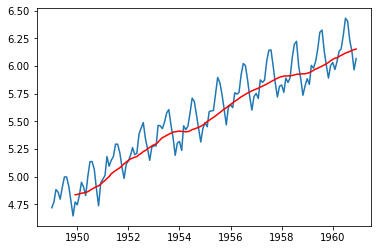

In [93]:
trend = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(trend, color='r');

Es importante fijarse en que **no hay valores para las primeras 11 posiciones de la serie**, ya que se pierden en el cálculo. Se tiene que solucionar aplicando la **función dropna**.

In [94]:
print(trend.iloc[0:13])

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01    4.836178
1950-01-01    4.838381
Name: #Passengers, dtype: float64


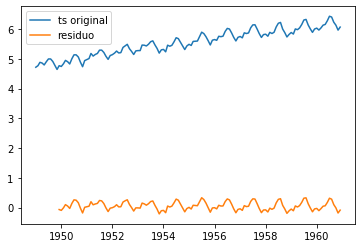

In [95]:
residuo=ts_log-trend
residuo=residuo.dropna() #Eliminamos los nulos producidos por el smoothing.
plt.plot(ts_log,label='ts original')
plt.plot(residuo,label='residuo')
plt.legend()
plt.show()

Vemos que **el residuo ya no tiene tendencia**

In [96]:
df(residuo,autolag='AIC')

(-3.162907991300849,
 0.022234630001244364,
 13,
 119,
 {'1%': -3.4865346059036564,
  '5%': -2.8861509858476264,
  '10%': -2.579896092790057},
 -436.63269481747125)

El **estadístico es ligeramente mayor que el valor crítico del 1%** (intervalo de confianza del 99%).

El **P-value es menor que 0.05**. 

Vemos que **el estadístico se resiste a marcar la serie como estacionaria al 99% de confianza**. Esto es **debido a que** hemos eliminado la tendencia pero **aún hay un componente estacionario**

### Weighted Moving Average

Usaremos una **media móvil con pesos asignados exponencialmente**. Se puede encontrar la **referencia** [aqui](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows)

Ahora **no necesitamos fijar una ventana para la media móvil puesto que todas las posiciones tienen asignadas un valor**. La ventaja es que no hay que decidir una longitud de ventana a priori y además**no se producen nulos**.

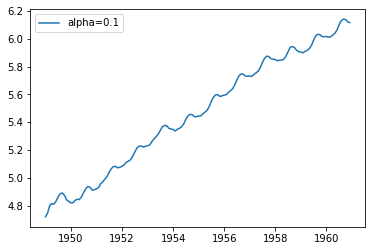

In [143]:
weighted_trend=ts_log.ewm(alpha=0.1).mean() #El parámetro alpha es un "regulador" del smoothing the la serie
plt.plot(weighted_trend,label='alpha=0.1')

plt.legend()
plt.show()

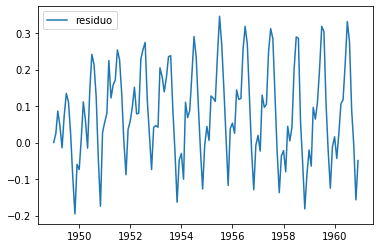

In [144]:
residuo=ts_log-weighted_trend
plt.plot(residuo,label='residuo')
plt.legend()
plt.show()

In [145]:
print(df(residuo,autolag='AIC'))

(-3.481886424011115, 0.008464658945468228, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, -472.2291279245943)


El **resultado ahora** es **un poco mejor que con la media móvil tradicional** pero el **estadístico aún no** está **por debajo del valor crítico del 1%**

## Modelizando y eliminando la parte estacional

El modulo **statsmodels.tsa.seasonal.seasonal_decompose extrae la parte estacional**

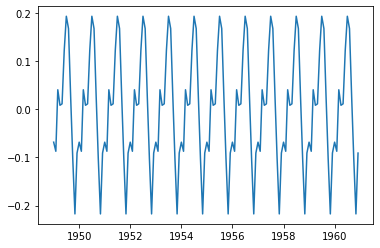

In [146]:
from statsmodels.tsa.seasonal import seasonal_decompose as season

out=season(residuo) #Introducimos ts_log-trend dentro del módulo
seasonal=out.seasonal #Extraemos del resultado la componente estacional
plt.plot(seasonal)

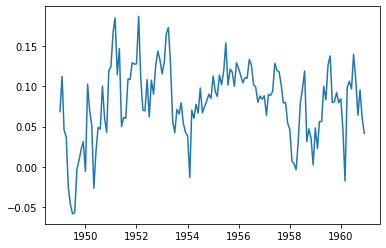

In [147]:
residuo=residuo-seasonal
plt.plot(residuo)
plt.show()

In [148]:
print(df(residuo,autolag='AIC'))

(-4.7838872205787055, 5.838020087363835e-05, 0, 143, {'1%': -3.4769274060112707, '5%': -2.8819726324025625, '10%': -2.577665408088415}, -527.4269278895512)


**UNA VEZ ELIMINADA LA PARTE ESTACIONAL EL TEST DF DA QUE EL RESIDUO YA ES ESTACIONARIO**

## Usando seasonal_decompose para extraer las tres componentes: tendencia, estacionalidad y residuo

El modulo **seasonal_decompose extrae en realidad las tres componente de una sola vez**

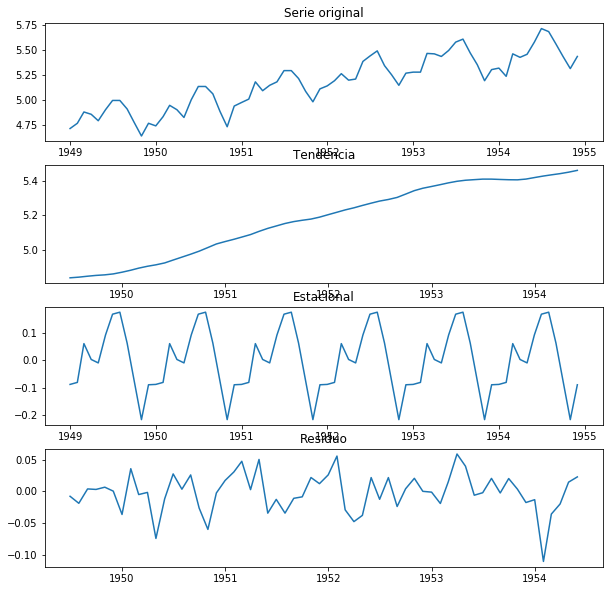

In [519]:
out=season(ts_log)
seasonal=out.seasonal
trend=out.trend
residuo=out.resid
plt.figure(figsize=(10,10))
plt.subplot(411)
plt.title('Serie original')
plt.plot(ts_log)
plt.subplot(412)
plt.title('Tendencia')
plt.plot(trend)
plt.subplot(413)
plt.title('Estacional')
plt.plot(seasonal)
plt.subplot(414)
plt.title('Residuo')
plt.plot(residuo)
plt.show()

In [520]:
#Aplicamos el test DF para ver resultados sobre el residuo obtenido de esta forma
residuo=residuo.dropna() #Eliminamos nulos
df(residuo,autolag='AIC')

(-5.944573503426674,
 2.2198166959470318e-07,
 0,
 59,
 {'1%': -3.5463945337644063,
  '5%': -2.911939409384601,
  '10%': -2.5936515282964665},
 -195.82960401741076)

**LOS RESULTADOS SON MEJORES CALCULANDO LAS TRES COMPONENTES CON ESTE MÉTODO** (al menos para esta serie)

# Modelización de la componente estacionaria

Un método bastante estándar es usar un **modelo ARIMA**.Tiene **tres componentes**:

   - **Componente autorregresiva**: El valor de la serie en k (s(k)) se calcula como una **combinación lineal de valores pasados en el tiempo de la propia serie** (s(k-1), s(k-2), etc.)
   
   - **Componente integrada**: Realiza **diferencias sobre valores de la serie**, es una forma de **extraer la tendencia**, si la hubiera.
   
   - **Componente de medias móviles**: **Combinación lineal** sobre los **errores que se van cometiendo en la componente autoregresiva**.
   
   - Un modelo **ARIMA (p,d,q)** indica el **número de elementos de cada componente** en el modelo:
   
       * **p** indica el número de elementos que tiene la parte autorregresiva.
       
       * **d** indica el número de diferenciaciones en la parte integrada.
       
       * **q** indica el número de elementos de la parte de media móvil.

## Ajuste del modelo

In [581]:
from statsmodels.tsa.arima_model import ARIMA as arima
model=arima(residuo,order=(5,1,1)) #Definimos el modelo
results=model.fit() #Entrenamos/ajustamos el modelo

C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


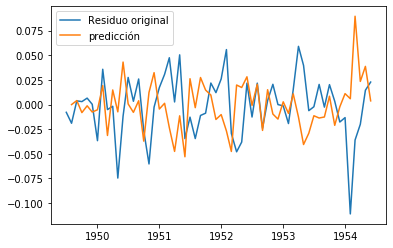

In [582]:
plt.plot(residuo,label='Residuo original')
plt.plot(results.fittedvalues,label='predicción')
plt.legend()
plt.show()

## Visualización del modelo

In [585]:
print(results.params)

const                 -0.000028
ar.L1.D.#Passengers    0.220985
ar.L2.D.#Passengers    0.070034
ar.L3.D.#Passengers   -0.255821
ar.L4.D.#Passengers   -0.098935
ar.L5.D.#Passengers    0.091787
ma.L1.D.#Passengers   -0.999998
dtype: float64


## Evaluación del performance del ajuste (error cuadrático medio o rmse)

In [588]:
df1=pd.DataFrame(residuo.values,columns=['residuo'],index=residuo.index)
ajustes=results.fittedvalues
df2=pd.DataFrame(ajustes.values,columns=['ajustes'],index=ajustes.index)
df1=df1.join(df2)
df1['error cuadratico']=df1['residuo']-df1['ajustes']
df1['error cuadratico']=df1['error cuadratico'].apply(lambda x: x**2)
error_cuadratico=df1['error cuadratico'].mean()
error_cuadratico=np.sqrt(error_cuadratico)
print()
print('Error cuadrático:',error_cuadratico)



Error cuadrático: 0.04153482913435933


## Forecasting de la componente estacionaria

Más información aqui:
https://machinelearningmastery.com/make-sample-forecasts-arima-python/

In [733]:
print(residuo.tail()) # Visualizamos la última fecha disponible en la serie estacionaria

               serie
Month               
1954-02-01 -0.110963
1954-03-01 -0.036001
1954-04-01 -0.020004
1954-05-01  0.014518
1954-06-01  0.022820


Serie ends at: 60
First prediction in 61
Last prediction in 69


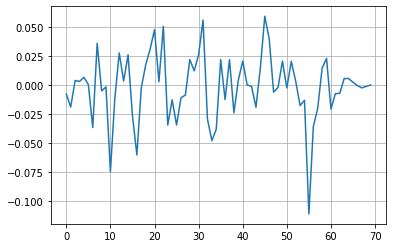

In [745]:
h=10 # HORIZONTE DE PREDICCIÓN
first_prediction=len(residuo)+1 # Fecha de inicio de la predicción=último valor de la serie + 1
final_prediction=start_date+(h-2) # Determinamos dónde queremos acabar la predicción

print('Serie ends at:',len(residuo))
print('First prediction in',first_prediction)
print('Last prediction in',final_prediction)

predictions=model.predict(params=results.params,start=first_prediction,end=final_prediction) #PREDICCIÓN

new_dates=pd.date_range('19540601',periods=h,freq='1M') #Generamos una serie de fechas para poner cómo indice en la predicción

'''
Se ponen tanto el resíduo como la predicción en formato dataframe para después conectarlos en una sola serie
'''
df_residuo=pd.DataFrame(residuo.values,index=residuo.index,columns=['serie'])
df_predictions=pd.DataFrame(predictions,index=new_dates,columns=['serie'])
serie_final=df_residuo.merge(df_predictions,how='outer',on='serie')

#Se dibuja la serie resultante
plt.grid()
plt.plot(serie_final)
plt.show()

**¿Qué ocurre al aumentar el horizonte de predicción?: aumenta el horizonte de predicción a 100**

A medida que se aumenta el horizonte de predicción el forecasting de cada nuevo punto se genera con puntos ya generados por predicción (que van acumulando un error cada vez mayor). Esto hace que a medida que aumenta h los puntos obtenidos sean menos fiables.

# Forecasting de la serie temporal global usando la componente estacionaria como función generadora

PROCEDIMIENTO:

1.- División de la serie en serie_training y serie_testing.

2.- Extracción de la serie estracionaria de ts_tr.

3.- Extracción de la señal generadora de ts_tr

4.- Ajuste de ts_tr usando una regresión lineal que usa como input la señal generadora.

5.- Uso del valor óptimo de lag y la regresión lineal entrenada con ts_tr para predecir valores futuros en ts_test

    

## 1.- División de la serie en training y testing datasets

In [19]:
porcentaje_en_ts_tr=0.5 #Trozo que queremos como dataset de training
lentgh=len(ts)
corte=int(porcentaje_en_ts_tr*lentgh) # Decidimos utilizar un 60% para training
'''
Cortamos la serie en dos
'''
ts_tr=ts[0:corte]
ts_test=ts[corte+1:]
print('Puntos en ts_tr',len(ts_tr))
print('Puntos en ts_test',len(ts_test))

Puntos en ts_tr 72
Puntos en ts_test 71


## 2 .- Extracción de la serie estracionaria de ts_tr

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose as decompose
'''
Primero suavizamos la serie
'''
ts_log_tr=np.log(ts_tr)

'''
Extraemos el residuo
'''
out=decompose(ts_log_tr)
residuo_tr=out.resid

'''
Se crea un dataframe pandas para ir poniendo los resultados de las diferentes componentes
'''
df_tr=pd.DataFrame(data=ts_log_tr.values,index=ts_log_tr.index,columns=['ts_log'])
df_tr['residuo']=residuo_tr.values
df_tr['serie']=ts_tr.values
df_tr=df_tr.dropna()

## 3.- Extracción de la señal generadora de ts_tr

In [21]:
from statsmodels.tsa.arima_model import ARIMA as arima

model_order=(2,0,1) #Definimos un modelo
model=arima(df_tr['residuo'].values,order=model_order) 
model=model.fit() #Modelo ajustado
estimaciones=model.fittedvalues
df_tr['est_residuo']=estimaciones

In [22]:
'''
Calculamos el error cuadrático medio de la estimación de la serie estacionaria
'''
df_tr['error']=df_tr['residuo']-df_tr['est_residuo']
df_tr['error']=df_tr['error'].apply(lambda x: x**2)
rmse=df_tr['error'].mean()
rmse=np.sqrt(rmse)
print('Error cuadrático medio:',rmse)

Error cuadrático medio: 0.029730280463523325


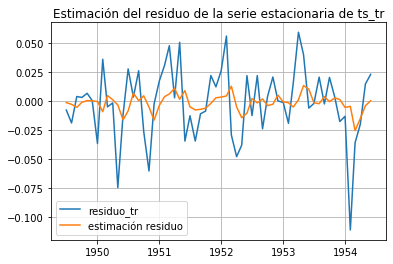

In [23]:
plt.plot(df_tr['residuo'],label='residuo_tr')
plt.plot(df_tr['est_residuo'],label='estimación residuo')
plt.title('Estimación del residuo de la serie estacionaria de ts_tr')
plt.legend()
plt.grid()
plt.show()

In [24]:
#Calculamos el acumulado de las estimaciones en una columna diferente
df_tr['est_cumsum']=df_tr['est_residuo'].cumsum() #Acumulado de las estimaciones
df_tr.head()

,ts_log,residuo,serie,est_residuo,error,est_cumsum
Month,,,,,,
1949-07-01,4.997212,-0.007864,148,-0.001478,0.000041,-0.001478
1949-08-01,4.997212,-0.018963,148,-0.002924,0.000257,-0.004402
1949-09-01,4.912655,0.003781,136,-0.005568,0.000087,-0.009970
1949-10-01,4.779123,0.002999,119,-0.001205,0.000018,-0.011175
1949-11-01,4.644391,0.006533,104,0.000265,0.000039,-0.010910


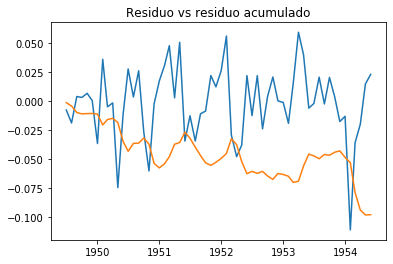

In [25]:
plt.plot(df_tr['residuo'])
plt.plot(df_tr['est_cumsum'])
plt.title('Residuo vs residuo acumulado')
plt.show()

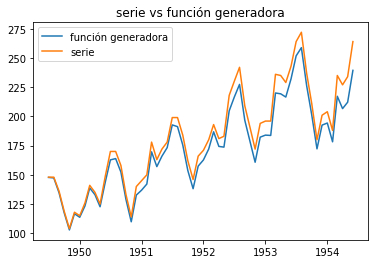

In [26]:
# SE SUMA RESIDUO (estimado) ACUMULADO A LA SERIE_LOG y se deshace la transformación lograrítmica.
#  el resultado se considera la FUNCIÓN GENERADORA

df_tr['est_log']=df_tr['ts_log']+df_tr['est_cumsum']
df_tr['est_serie']=np.exp(df_tr['est_log'].values)
plt.plot(df_tr['est_serie'],label='función generadora')
plt.plot(df_tr['serie'],label='serie')
plt.legend()
plt.title('serie vs función generadora')
plt.show()


## 4.- Ajuste de ts_tr usando una regresión lineal que usa como input la señal generadora

### 4.1 Ajuste de la serie training para un lag dado

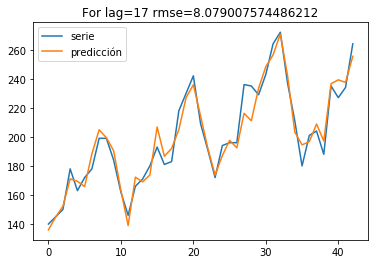

In [63]:
from sklearn.linear_model import LinearRegression as reg

x=[]
y=[]

feat_input='serie' #Seleccionamos la variable de entrada para el modelo
lag=17 #Seleccionamos retraso temporal para el modelo

for k in range(lag,len(df_tr)):
    x_value=df_tr[feat_input].iloc[k-lag:k].ravel()
    y_value=df_tr['serie'].iloc[k]
    x.append(x_value)
    y.append(y_value)
regresion=reg()
regresion.fit(x,y)
pred=regresion.predict(x)
rmse=np.mean((y-pred)**2)
rmse=np.sqrt(rmse)

plt.plot(y,label='serie')
plt.title('For lag='+str(lag)+' rmse='+str(rmse))
plt.plot(pred,label='predicción')
plt.legend()
plt.show()



### 4.2 Iteramos sobre varios valores de lag para ver cómo varía rsme

In [56]:
#DEFINIMOS UNA FUNCIÓN QUE CALCULE RMSE EN FUNCIÓN DEL LAG.
def lag_finder(df,feat_input,target,lag):
    from sklearn.linear_model import LinearRegression as reg

    x=[]
    y=[]


    
    for k in range(lag,len(df_tr)):
        x_value=df[feat_input].iloc[k-lag:k].ravel()
        y_value=df[target].iloc[k]
        x.append(x_value)
        y.append(y_value)
    regresion=reg()
    regresion.fit(x,y)
    pred=regresion.predict(x)
    rmse=np.mean((y-pred)**2)
    rmse=np.sqrt(rmse)

    plt.plot(y,label='serie')
    plt.title('For lag='+str(lag)+' rmse='+str(rmse))
    plt.plot(pred,label='predicción')
    plt.legend()
    plt.show()
    return rmse


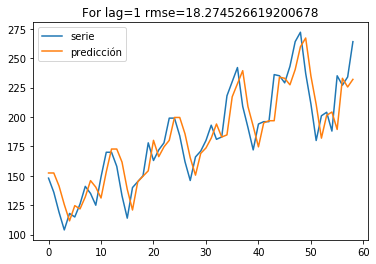

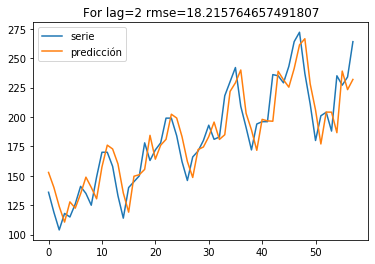

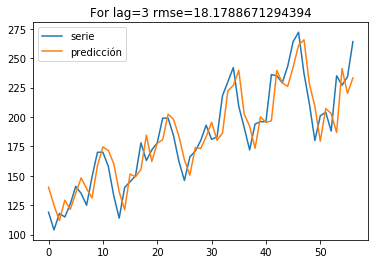

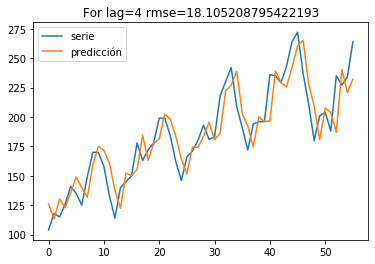

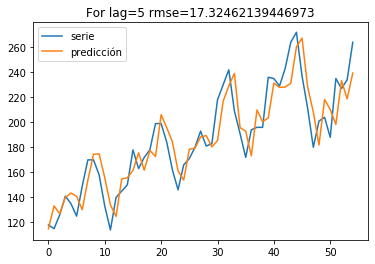

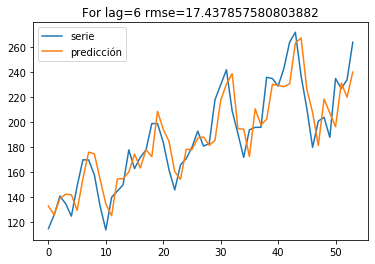

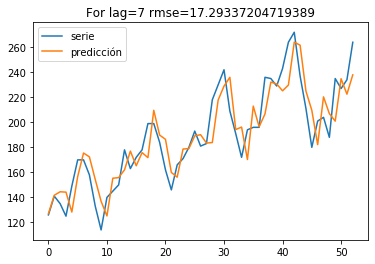

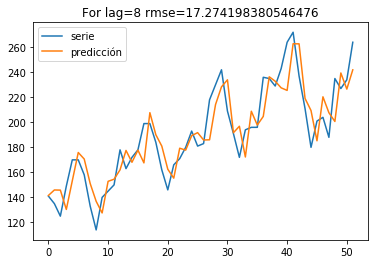

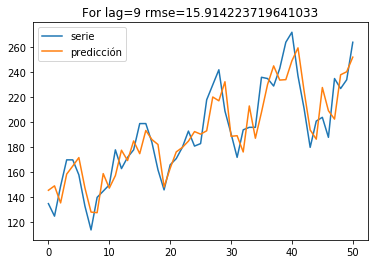

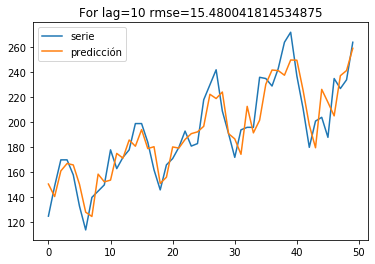

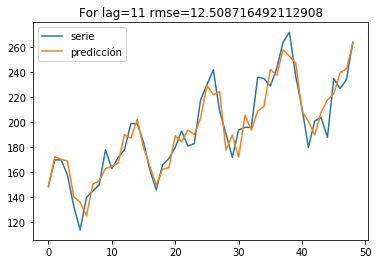

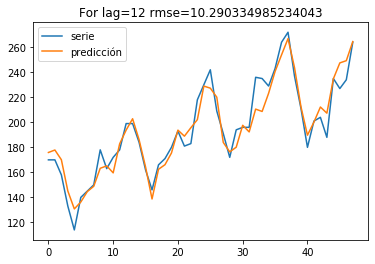

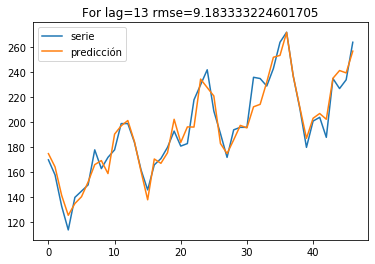

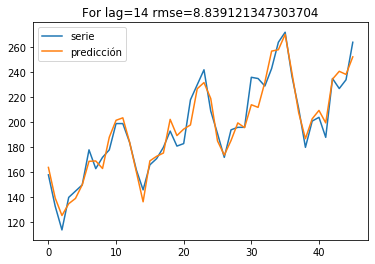

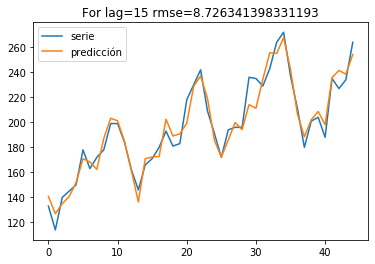

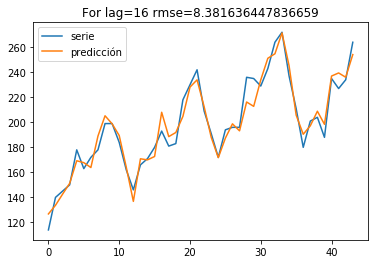

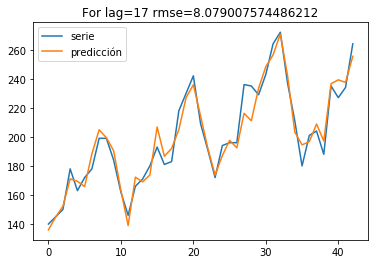

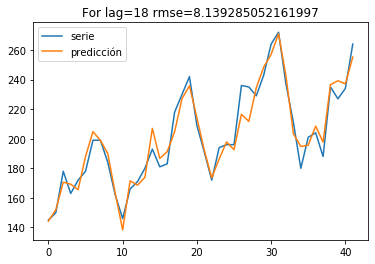

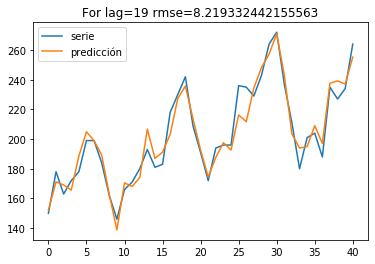

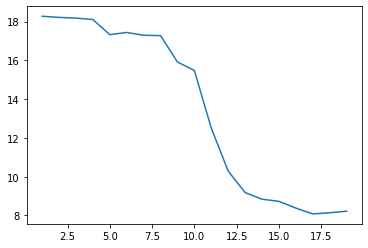

In [52]:

lags=[]
rmses=[]

for lag in range(1,20):
    out=lag_finder(df_tr,feat_input,target,lag)
    rmses.append(out)
    lags.append(lag)
plt.plot(lags,rmses)
plt.show()

## 5.- Uso del valor óptimo de lag y la regresión lineal entrenada con ts_tr para predecir valores futuros en ts_test

In [45]:
#DEFINIMOS UNA FUNCIÓN QUE CALCULE RMSE PARA UN LAG DADO,UNA SERIE GENÉRICA Y UN MODELO YA ENTRENADO.
def linear_model(x_serie,y_serie,lag,model):
   

    x=[]
    y=[]


    
    for k in range(0+lag,len(x_serie)):
        '''
        x_value=df_pred['est_serie'].iloc[k-lag:k].ravel()
        y_value=df_pred['serie'].iloc[k]
        '''
        
        x_value=x_serie.iloc[k-lag:k].ravel()
        y_value=y_serie.iloc[k]
        x.append(x_value)
        y.append(y_value)
   
    
    
    pred=model.predict(x)
    rmse=np.mean((y-pred)**2)
    rmse=np.sqrt(rmse)

    
    
    return [rmse,pred]

### Extracción de la señal generadora de la serie de testing

In [59]:
#Extraemos la señal generadora de la serie de testing
ts_log_test=np.log(ts_test)
residuo_test=decompose(ts_log_test).resid
'''
Definimos un dataframe (como hicimos para la serie de training)
'''
df_test=pd.DataFrame(ts_test.values,index=ts_test.index,columns=['serie'])
df_test['serie_log']=ts_log_test.values
df_test['residuo']=residuo_test
df_test=df_test.dropna()

model_order=(2,0,1) #Definimos el mismo modelo que usamos con la serie de training
model=arima(df_test['residuo'],order=model_order) 
model=model.fit() #Modelo ajustado
estimaciones_test=model.fittedvalues

df_test['est_residuo']=estimaciones_test

df_test['est_cumsum']=df_test['est_residuo'].cumsum() #Acumulado de las estimaciones
df_test['est_log']=df_test['serie_log']+df_test['est_cumsum']
df_test['est_serie']=np.exp(df_test['est_log'].values)




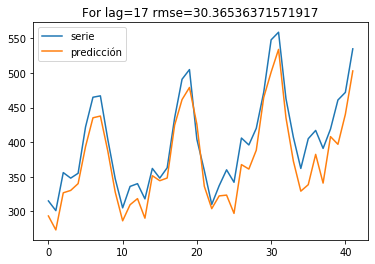

In [64]:
x=[]
y=[]


lag=17 #MISMO LAG CON EL QUE HEMOS ENTRENADO EL MODELO PARA ts_tr

#OJO, ESTE MODELO TIENE QUE HABER SIDO ENTRENADO PREVIAMENTE CON EL LAG ÓPTIMO Y LA SERIE TRAINING
out=linear_model(df_test[feat_input],df_test['serie'],lag,regresion) 
rmse=out[0]
pred=out[1]


n_2_predict=len(df_test)-lag #Al predecir con retardos temporales perdemos un tramo inicial de la serie. Se predice sobre el tramo restante
df_result=pd.DataFrame(df_test['serie'].iloc[-n_2_predict:],index=df_test['serie'].iloc[-n_2_predict:].index)
df_result['pred']=pred
rmse=np.mean((df_test['serie'].iloc[-n_2_predict:]-df_result['pred'])**2)
rmse=np.sqrt(rmse)

plt.plot(df_result['serie'].values,label='serie')
plt.title('For lag='+str(lag)+' rmse='+str(rmse))
plt.plot(df_result['pred'].values,label='predicción')
plt.legend()
plt.show()


# EJERCICIO 1

**REPETIR EL AJUSTE DEL MODELO LINEAL CON ts_tr Y VUELVE A HACER PREDICCIÓN PARA ts_test pero esta vez usando como variable input el campo 'serie'**. Es decir ahora no se ha de usar la señal generadora sino los propios valores de la serie (retrasados en el tiempo con su lag correspondiente).

**COMPROBAR RESULTADOS PARA AMBOS ENFOQUES.**

# EJERCICIO 2

**Discusión: ¿Por qué el performance del ajuste en ts_tr es mejor que en ts_test?**

# ................................................................

In [413]:
lags=[]
diffs=[]
for lag in range(1,2):
    rmse_tr=linear_model(df_pred['est_serie'],df_pred['serie'],lag)
    rmse_test=linear_model(df_test['est_serie'],df_test['serie'],lag)
    print('pasé')
    diff=rmse_test-rmse_tr
    diffs.append(diff)
    lags.append(lag)
    
plt.plot(lags,diffs)
plt.show()

TypeError: linear_model() missing 1 required positional argument: 'model'

In [523]:
#Ahora hacemos forecasting sobre la serie original sin procesar (sin extraer tendencia y estacionalidad)

model=arima(ts_log,order=(5,1,1)) #Definimos el modelo pero ahora con la serie original
results=model.fit() #Entrenamos/ajustamos el modelo



C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [524]:
predicciones=results.fittedvalues
df1=pd.DataFrame(predicciones.values,columns=['predicciones'],index=predicciones.index)
df2=pd.DataFrame(ts_log.values,index=ts_log.index,columns=['serie'])

df1=df1.join(df2)
df1['error cuadratico']=df1['serie']-df1['predicciones']
df1['error cuadratico']=df1['error cuadratico'].apply(lambda x: x**2)
error_cuadratico=df1['error cuadratico'].mean()
error_cuadratico=np.sqrt(error_cuadratico)
print()
print('Error cuadrático:',error_cuadratico)


Error cuadrático: 5.1807901373282


In [285]:
df1.head(100)

,predicciones,serie,error cuadratico
Month,,,
1949-02-01,0.010101,4.770685,22.663156
1949-03-01,0.018697,4.882802,23.659517
1949-04-01,0.027209,4.859812,23.354057
1949-05-01,-0.016932,4.795791,23.162302
1949-06-01,-0.013904,4.905275,24.198318
...,...,...,...
1957-01-01,0.073540,5.752573,32.251411
1957-02-01,0.053122,5.707110,31.967589
1957-03-01,0.083907,5.874931,33.535957


## Función para calcular los estados de la serie temporal

In [561]:
N=len(ts_log)
N=int(round(N,0))
N_tr=int(N/2)
ts_tr=ts_log.iloc[0:N_tr]
ts_test=ts_log.iloc[N_tr+1:N]
print(len(ts_tr))
print(len(ts_test))


72
71


In [570]:
def extract_states(time_series,arima_vector):
    from statsmodels.tsa.seasonal import seasonal_decompose as season
    from statsmodels.tsa.arima_model import ARIMA as arima
    output=season(time_series)
    residuo=output.resid
    residuo=residuo.dropna()
    model=arima(residuo,order=arima_vector) #Definimos el modelo
    results=model.fit() #Entrenamos/ajustamos el modelo
    states=results.fittedvalues
    return states

In [571]:
arima_vector=(5,1,1)
states_tr=extract_states(ts_tr,arima_vector)
states_test=extract_states(ts_test,arima_vector)

C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


# Linear Regression

Will need to recreate the data to properly fit into a Linear Regression model

## ARIMA

In [525]:
predictions = pd.Series(results.fittedvalues, copy=True)
predictions.head()

Month
1949-02-01    0.011321
1949-03-01    0.016906
1949-04-01    0.020023
1949-05-01   -0.015552
1949-06-01   -0.010370
dtype: float64

In [526]:
predictions_cumsum = predictions.cumsum()
predictions_cumsum.head()

Month
1949-02-01    0.011321
1949-03-01    0.028227
1949-04-01    0.048250
1949-05-01    0.032698
1949-06-01    0.022328
dtype: float64

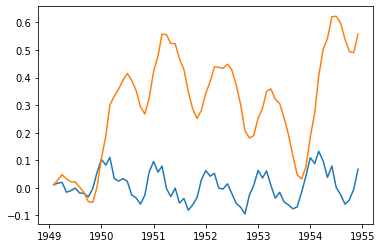

In [527]:
plt.plot(predictions)
plt.plot(predictions_cumsum)

In [528]:
predictions_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)
predictions_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.729820
1949-03-01    4.746726
1949-04-01    4.766748
1949-05-01    4.751197
dtype: float64

Text(0.5, 1.0, 'RMSE: nan')

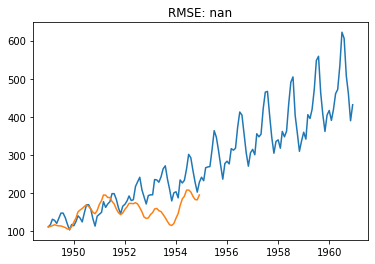

In [529]:
predictions_ARIMA = np.exp(predictions_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f' % np.sqrt(sum((predictions_ARIMA - ts)**2)/len(ts)))

## SKLearn

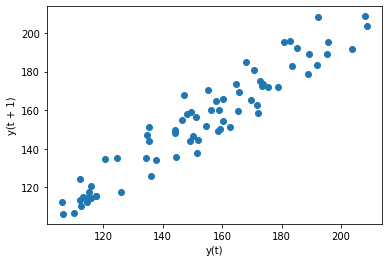

In [530]:
# Quick check using a lag plot to show correlation
from pandas.plotting import lag_plot, autocorrelation_plot
   
ts_lag = lag_plot(predictions_ARIMA,lag=1)
plt.show()

C:\Users\juanh\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


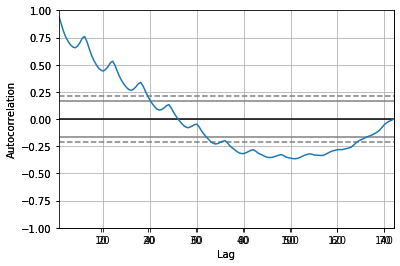

In [531]:
autocorrelation_plot(predictions_ARIMA)
autocorrelation_plot(ts)
plt.show()

In [575]:
lag=4
x_tr = []
y_tr = []
#For train
for d in range(lag,states_tr.shape[0]):
    x = predictions_ARIMA.iloc[d-lag:d].ravel()
    y = predictions_ARIMA.iloc[d]
    x_tr.append(x)
    y_tr.append(y)
#For test
x_test = []
y_test = []
#For train
for d in range(lag,states_tr.shape[0]):
    x = predictions_ARIMA.iloc[d-lag:d].ravel()
    y = predictions_ARIMA.iloc[d]
    x_test.append(x)
    y_test.append(y)

In [532]:
def find_lag(arima_predictions,ts,lag):
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    x_data = []
    y_data = []

    for d in range(lag,arima_predictions.shape[0]):
        x =arima_predictions.iloc[d-lag:d].ravel()
        y = arima_predictions.iloc[d]
        x_data.append(x)
        y_data.append(y)
    train, test, label_train, label_test = \
    train_test_split(x_data, y_data, test_size=0.33)
    lr = LinearRegression()
    lr.fit(train, label_train)
    y_pred = lr.predict(test)
    print('Predicted RMSE =', np.sqrt(mean_squared_error(label_test, y_pred)))
    plt.plot(np.array(label_test), label='actual')
    plt.plot(y_pred, label='forecast')
    plt.legend()
    plt.show()
    rmse=np.sqrt(mean_squared_error(label_test, y_pred))
    return rmse

lag: 1
Predicted RMSE = 0.02441568336396326


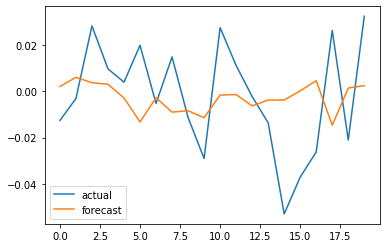

lag: 2
Predicted RMSE = 0.020607316319551396


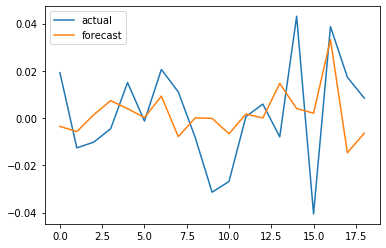

lag: 3
Predicted RMSE = 0.03256586442050953


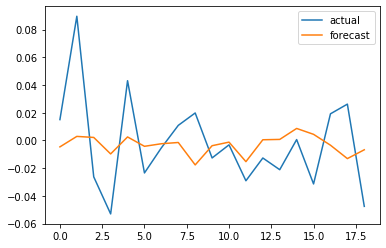

lag: 4
Predicted RMSE = 0.017364420489769532


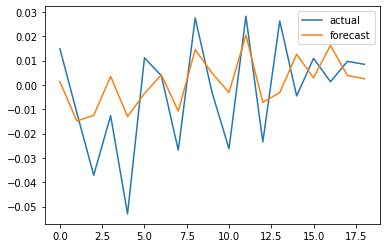

lag: 5
Predicted RMSE = 0.023037650624918856


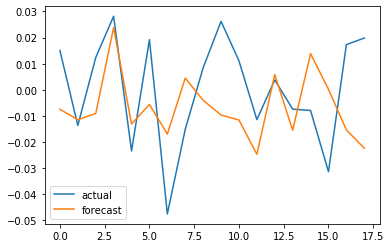

lag: 6
Predicted RMSE = 0.02826585005152136


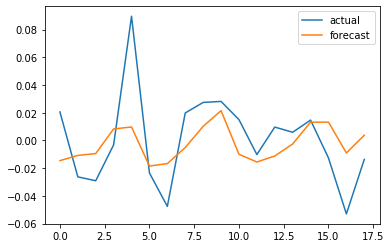

lag: 7
Predicted RMSE = 0.02757801804886586


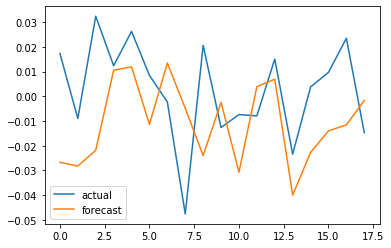

lag: 8
Predicted RMSE = 0.0306575813870592


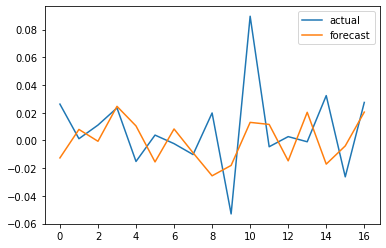

lag: 9
Predicted RMSE = 0.028421560502319743


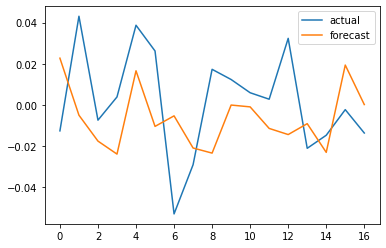

<function matplotlib.pyplot.show(*args, **kw)>

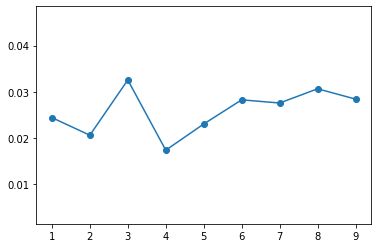

In [573]:
lags=np.arange(1,10)
rmses=[]
for lag in lags:
    print('lag:',lag)
    out=find_lag(states_tr,ts,lag)
    rmses.append(out)
plt.scatter(lags,rmses)
plt.plot(lags,rmses)
plt.show

In [501]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

train, test, label_train, label_test = \
    train_test_split(x_data, y_data, test_size=0.33)

In [577]:
train=x_tr
test=x_test
label_train=y_tr
label_test=y_test

In [578]:
lr = LinearRegression()
lr.fit(train, label_train)

LinearRegression()

In [579]:
y_pred = lr.predict(test)

Predicted RMSE = 4.708296324268922


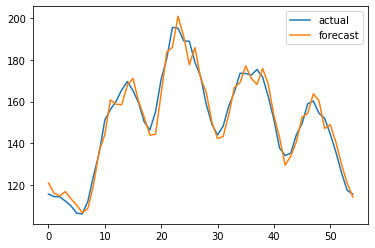

In [580]:
from sklearn.metrics import mean_squared_error

print('Predicted RMSE =', np.sqrt(mean_squared_error(label_test, y_pred)))
plt.plot(np.array(label_test), label='actual')
plt.plot(y_pred, label='forecast')
plt.legend()
plt.show()